In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!!pip install tqdm


['Requirement already satisfied: tqdm in /usr/local/lib/python3.7/dist-packages (4.64.0)']

In [4]:
import pandas as pd 
import numpy as np
import time
import cv2
import os
import pickle
from tqdm.notebook import tqdm

In [5]:


from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, add,Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate

from tensorflow.image import grayscale_to_rgb
from tensorflow import constant
import tensorflow 
from tensorflow.compat.v1.keras.layers import CuDNNLSTM



from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential


from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate


CSV file reading

In [6]:
data= pd.read_csv("/content/drive/MyDrive/Captioning_data/stanford_df_rectified.csv")

In [7]:
data.head(3)

,Image_name,Paragraph,train,test,url,val
0,2356347,A large building with bars on the windows in f...,False,True,https://cs.stanford.edu/people/rak248/VG_100K/...,False
1,2317429,A white round plate is on a table with a plast...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
2,2414610,A woman in a blue tennis outfit stands on a gr...,False,True,https://cs.stanford.edu/people/rak248/VG_100K_...,False


In [8]:
data["Image_name"]=data["Image_name"].map(str)

In [9]:
# collelction of keys 
train=list(data.loc[data["train"]==True]["Image_name"])
test=list(data.loc[data["test"]==True]["Image_name"])
validation=list(data.loc[data["val"]==True]["Image_name"])

In [10]:
from tensorflow.keras.applications import ResNet50
incept_model = ResNet50(include_top=True)

last = incept_model.layers[-2].output
extractor = Model(inputs = incept_model.input,outputs = last)
extractor.summary()



102981632/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

Caption Filtering

In [11]:
# create mapping of image to captions
mapping = {}
# process lines
for index,row in tqdm(data.iterrows()):

    image_id, caption = row["Image_name"],row["Paragraph"]
    # print(image_id)
    caption=caption.split(".")
    
    mapping[image_id]=caption[:-1]

0it [00:00, ?it/s]

In [12]:
mapping["2383120"]

['A very clean and tidy a bathroom',
 ' Everything is a neat porcelain white',
 ' This bathroom is both retro and modern']

In [13]:
len(mapping)

19551

In [14]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [15]:
# preprocess the text
clean(mapping)

In [16]:
mapping["2383120"]

['startseq very clean and tidy bathroom endseq',
 'startseq everything is neat porcelain white endseq',
 'startseq this bathroom is both retro and modern endseq']

Feature extraction:

In [20]:
images_path="/content/drive/MyDrive/Captioning_data/stanford_img/content/stanford_images"

def feature_extractor(img_id):
    img = cv2.imread(os.path.join(images_path,f"{img_id}.jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img.reshape(1,224,224,3)
    pred = extractor.predict(img).reshape(2048,)   
    return(pred)


In [21]:
feature_extractor('121').shape

(2048,)

In [ ]:
features = dict()
for key in tqdm(mapping.keys(), total = len(mapping.keys())):
    feature = feature_extractor(key)
    features[key] = feature

  0%|          | 0/19551 [00:00<?, ?it/s]

In [ ]:
# Save  features By using pickle
pickle.dump(features, open(os.path.join(PATH, 'features_resnet50.pkl'), 'wb'))

In [5]:
# pip install --ignore-installed --upgrade tensorflow

In [9]:
# data= pd.read_csv("stanford_df_rectified.csv")

In [10]:
# data.head(10)

In [11]:
# #' ' means CPU whereas '/device:G:0' means GPU
# import tensorflow as tf
# tf.test.gpu_device_name()

In [17]:
BASE_DIR="G:/My Drive/Captioning_data/stanford_img/content"

In [18]:
directory = os.path.join(BASE_DIR, 'stanford_images')
path="/content/drive/MyDrive/Captioning_data/stanford_img/content"

In [16]:
# # create mapping of image to captions
# mapping = {}
# # process lines
# for index,row in tqdm(data.iterrows()):

#     image_id, caption = row["Image_name"],row["Paragraph"]
#     # print(image_id)
#     caption=caption.split(".")
    
#     mapping[image_id]=caption[:-1]

0it [00:00, ?it/s]

In [19]:
# load features from pickle
with open(os.path.join(path,'features_resnet50.pkl'), 'rb') as f:
    features = pickle.load(f)

FileNotFoundError: ignored

In [17]:
# mapping["2383120"]

['A very clean and tidy a bathroom',
 ' Everything is a neat porcelain white',
 ' This bathroom is both retro and modern']

In [18]:
# len(mapping)

19551

In [20]:
# def clean(mapping):
#     for key, captions in mapping.items():
#         for i in range(len(captions)):
#             # take one caption at a time
#             caption = captions[i]
#             # preprocessing steps
#             # convert to lowercase
#             caption = caption.lower()
#             # delete digits, special chars, etc., 
#             caption = caption.replace('[^A-Za-z]', '')
#             # delete additional spaces
#             caption = caption.replace('\s+', ' ')
#             # add start and end tags to the caption
#             caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
#             captions[i] = caption

In [22]:
# mapping["2383120"]

['startseq very clean and tidy bathroom endseq',
 'startseq everything is neat porcelain white endseq',
 'startseq this bathroom is both retro and modern endseq']

Text data preprocessing

In [23]:
# create list of all caption
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [24]:
len(all_captions)

112024

In [25]:
all_captions[:10]

['startseq large building with bars on the windows in front of it endseq',
 'startseq there is people walking in front of the building endseq',
 'startseq there is street in front of the building with many cars on it endseq',
 'startseq white round plate is on table with plastic tablecloth on it endseq',
 'startseq two foil covered food halves are on the white plate along with serving of golden yellow french fries endseq',
 'startseq next to the white plate in short, topless, plastic container is white sauce endseq',
 'startseq diagonal to the white plate are the edges of several other stacked plates endseq',
 'startseq there are black shadows reflected on the table endseq',
 'startseq woman in blue tennis outfit stands on green tennis court endseq',
 'startseq she is swinging blue tennis racket endseq']

In [26]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [27]:
vocab_size

12656

In [30]:
# get maximum length of the caption available
# max_length = max(len(caption.split()) for caption in all_captions)
# max_length

81

In [31]:
max_count=0
max_length=0
for caption in all_captions:
  if len(caption.split())>max_count:
    max_length=len(caption.split())
    required_caption=caption
print(required_caption,max_length)

startseq the women is sitting down while looking at the dog endseq 12


In [ ]:
# max_length=66

In [32]:
len(required_caption)

66

In [34]:

# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


In [35]:
!mkdir -p /content/drive/MyDrive/Captioning_data/stanford_img/content/saved_model
!mkdir -p /content/drive/MyDrive/Captioning_data/stanford_img/content/training_1

MODEL 1


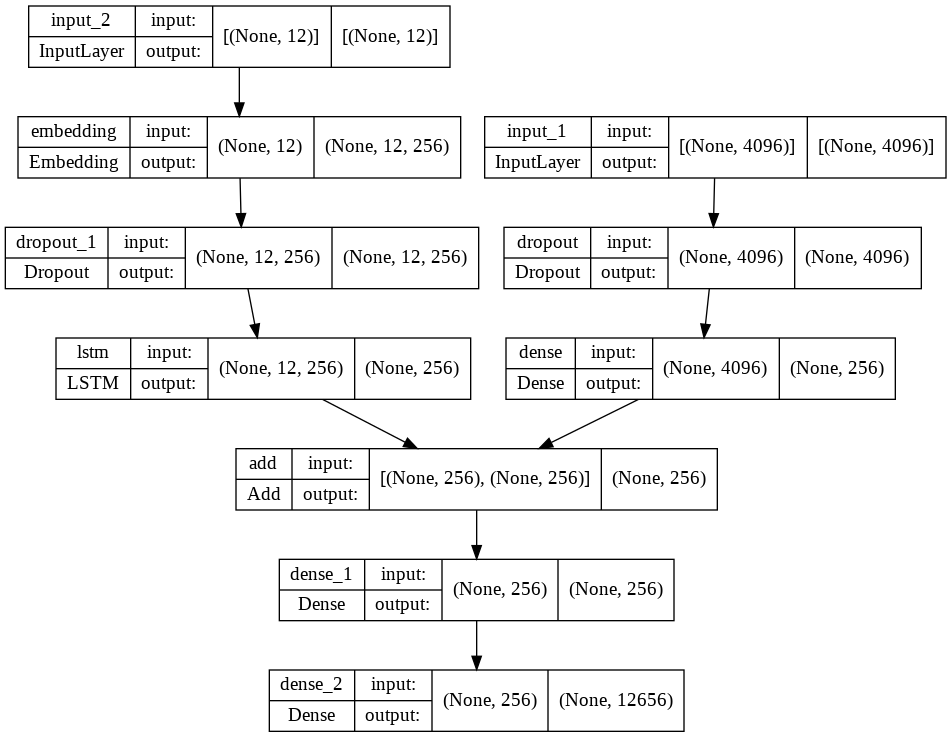

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

Model 2

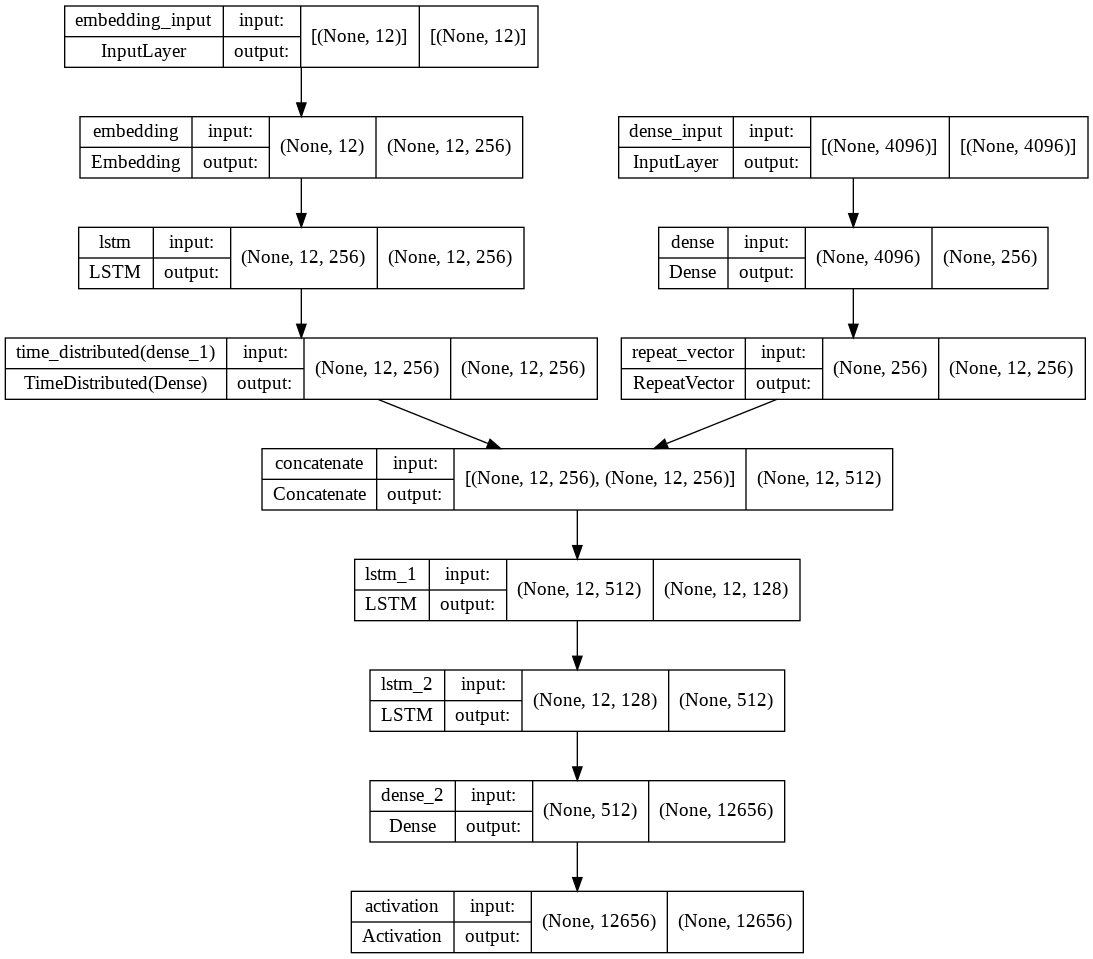

In [36]:
embedding_size = 256
max_len = 12
vocab_size = vocab_size

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(4096,), activation='relu'))
image_model.add(RepeatVector(max_len))

# image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

# language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model2 = Model(inputs=[image_model.input, language_model.input], outputs = out)
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# model.load_weights("../input/model_weights.h5")
model2.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# model2.summary()
plot_model(model2, show_shapes=True)

In [37]:
# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = "/content/drive/MyDrive/Captioning_data/stanford_img/content/saved_model"+checkpoint

# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                #  save_weights_only=True,
                                                #  verbose=1)

# train the model
epochs = 10
batch_size = 100
no_of_batches = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model2.fit(generator, epochs=1, steps_per_epoch=no_of_batches, verbose=1)

145/145 [==============================] - 164s 1s/step - loss: 3.2446 - accuracy: 0.3658


In [49]:
model2.save('saved_model/model2_epoch_10_no_glove.h5')

In [ ]:

# batch_size = 32
# no_of_batches = len(train) // batch_size

# generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# model.fit(generator, epochs=30, steps_per_epoch=no_of_batches, verbose=1,shuffle=True, workers=1,use_multiprocessing=True)

Epoch 1/30
455/455 [==============================] - 235s 497ms/step - loss: 4.3569
Epoch 2/30
455/455 [==============================] - 214s 470ms/step - loss: 3.4766
Epoch 3/30
455/455 [==============================] - 214s 470ms/step - loss: 3.2071
Epoch 4/30
455/455 [==============================] - 214s 469ms/step - loss: 3.0405
Epoch 5/30
455/455 [==============================] - 214s 471ms/step - loss: 2.9185
Epoch 6/30
455/455 [==============================] - 213s 469ms/step - loss: 2.8216
Epoch 7/30
455/455 [==============================] - 213s 469ms/step - loss: 2.7432
Epoch 8/30
455/455 [==============================] - 213s 467ms/step - loss: 2.6792
Epoch 9/30
455/455 [==============================] - 214s 469ms/step - loss: 2.6259
Epoch 10/30
455/455 [==============================] - 214s 471ms/step - loss: 2.5784
Epoch 11/30
455/455 [==============================] - 213s 469ms/step - loss: 2.5389
Epoch 12/30
455/455 [==============================] - 213s 467

In [ ]:
ls

drive/  sample_data/


In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model("saved_model/30_epoch_without for_loop_.h5")

OSError: ignored

In [50]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word 
    return None

In [51]:
# generate caption for an image
def predict_caption(new_model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = new_model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:

# from nltk.translate.bleu_score import corpus_bleu
# # validate with test data
# actual, predicted = list(), list()

# for key in tqdm(validation):
#     # get actual caption
#     captions = mapping[key]
#     # predict the caption for image
#     y_pred = predict_caption(model, features[key], tokenizer, max_length) 
#     # split into words
#     actual_captions = [caption.split() for caption in captions]
#     y_pred = y_pred.split()
#     # append to the list
#     actual.append(actual_captions)
#     predicted.append(y_pred)

# # calcuate BLEU score
# print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [52]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    # img_path = os.path.join(path, "stanford_images", image_name)
    img_path = os.path.join("/content/drive/MyDrive/Captioning_data/stanford_img/content/stanford_images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model2, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

  0%|          | 0/10 [00:00<?, ?it/s]

---------------------Actual---------------------
startseq group of men stand in the snow with skis endseq
startseq there are many snow covered trees behind the skiers endseq
startseq there is another group of men off in the distance endseq
startseq the skiers are all dressed in warm clothing endseq
startseq the sky above them is gray endseq
--------------------Predicted--------------------
startseq the man is wearing black jacket endseq
---------------------Actual---------------------
startseq small short haired brown dog walks down the street, holding skateboard in its mouth endseq
startseq the board's underside is pink and aqua endseq
startseq its wheels are red endseq
startseq the dog has body collar on it endseq
startseq its body has black spots endseq
--------------------Predicted--------------------
startseq the dog is wearing black shirt endseq
---------------------Actual---------------------
startseq there's bottle of wine on the table with black label endseq
startseq on the la

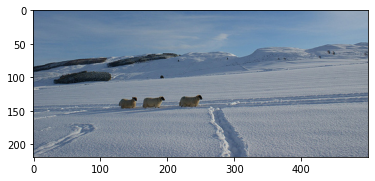

In [53]:

# #  validate first 10 image 
# for key in tqdm(validation[:10]):
#     Image_name=key+".jpg"
#     generate_caption(Image_name)


---------------------Actual---------------------
startseq red airplane soaring high into the clear blue sky as two smoke trails bellow from the plan engines endseq
--------------------Predicted--------------------
startseq the plane is white and white endseq


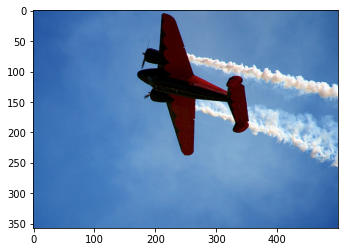

In [59]:
Image_name=validation[1000]+".jpg"
generate_caption(Image_name)

In [ ]:
print 

NameError: ignored